## Network Intrusion detection

### 1. Importing the required dependencies  


In [19]:
# Utils
import wfdb as wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request

# For data preprocessing and interpretation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_score, f1_score, roc_auc_score, confusion_matrix, recall_score

# pyod's anomaly detection models
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF
from pyod.models.copod import COPOD

### 2. Loading the KDD Cup 1999 dataset

The KDD Cup Dataset: 
- Contains 41 features describing network traffic packets and is a standard in testing and training intrusion detection models.
- The anomalies present are  <u> local </u> due to the packets' nature - even the variation of a single parameter (ex.: su_attempted (was super user login attempted or not - 0 or 1)) can imply an attack.
- Some attacks are highly specific and their presence can be determined by a few parameters (ex. NMAP - Scanning attack:  high rerror_rate) or by significantly many (DDOS - syn/ack rates, diff_srv_rate and many more). 

In [20]:
# Dataset URL
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
local_file = "kddcup.data_10_percent.gz"

# Download the dataset if it does not exist
if not os.path.exists(local_file):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, local_file)
    print("Download complete.")

# Contents of the dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

data = pd.read_csv(local_file, compression='gzip', header=None, names=column_names)

# Display the first few rows of the dataset
print(data.head())

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3           

### 3. Exploring the dataset

Let's plot some of the most important features of the dataset:
- hot: flag for suspicios activity (entering sys directories, acces of .dll's etc.)
- logged_in: 0 or 1 for sys login
- num_compromised: number of compromised conditions
- root_shell: was ~ acces achieved
- su_attempted: was super user acces tried
- count: connections to the same host in the last 2 seconds
- srv_count: connections to the same service in the last seconds (HTTP/S, FTP etc.)
- serror_rate: % of connections with SYN (Syncronize) Errors - possible port starvation
- dst_host_diff_srv_rate: % of connections to different services among the connections to the same host 
- dst_host_same_src_port_rate: % of connections to the same service coming from the same source port    
- dst_host_srv_diff_host_rate: % of connections to the same service coming from different hosts         
- dst_host_serror_rate: % of connections to the same host that have "SYN" errors                        
- dst_host_srv_serror_rate: % of connections to the same service that have "SYN" errors    

The last five are a good marker of frequent combinations: NMAP (reconnaisance) + DOS/DDOS (flood/denial of service)

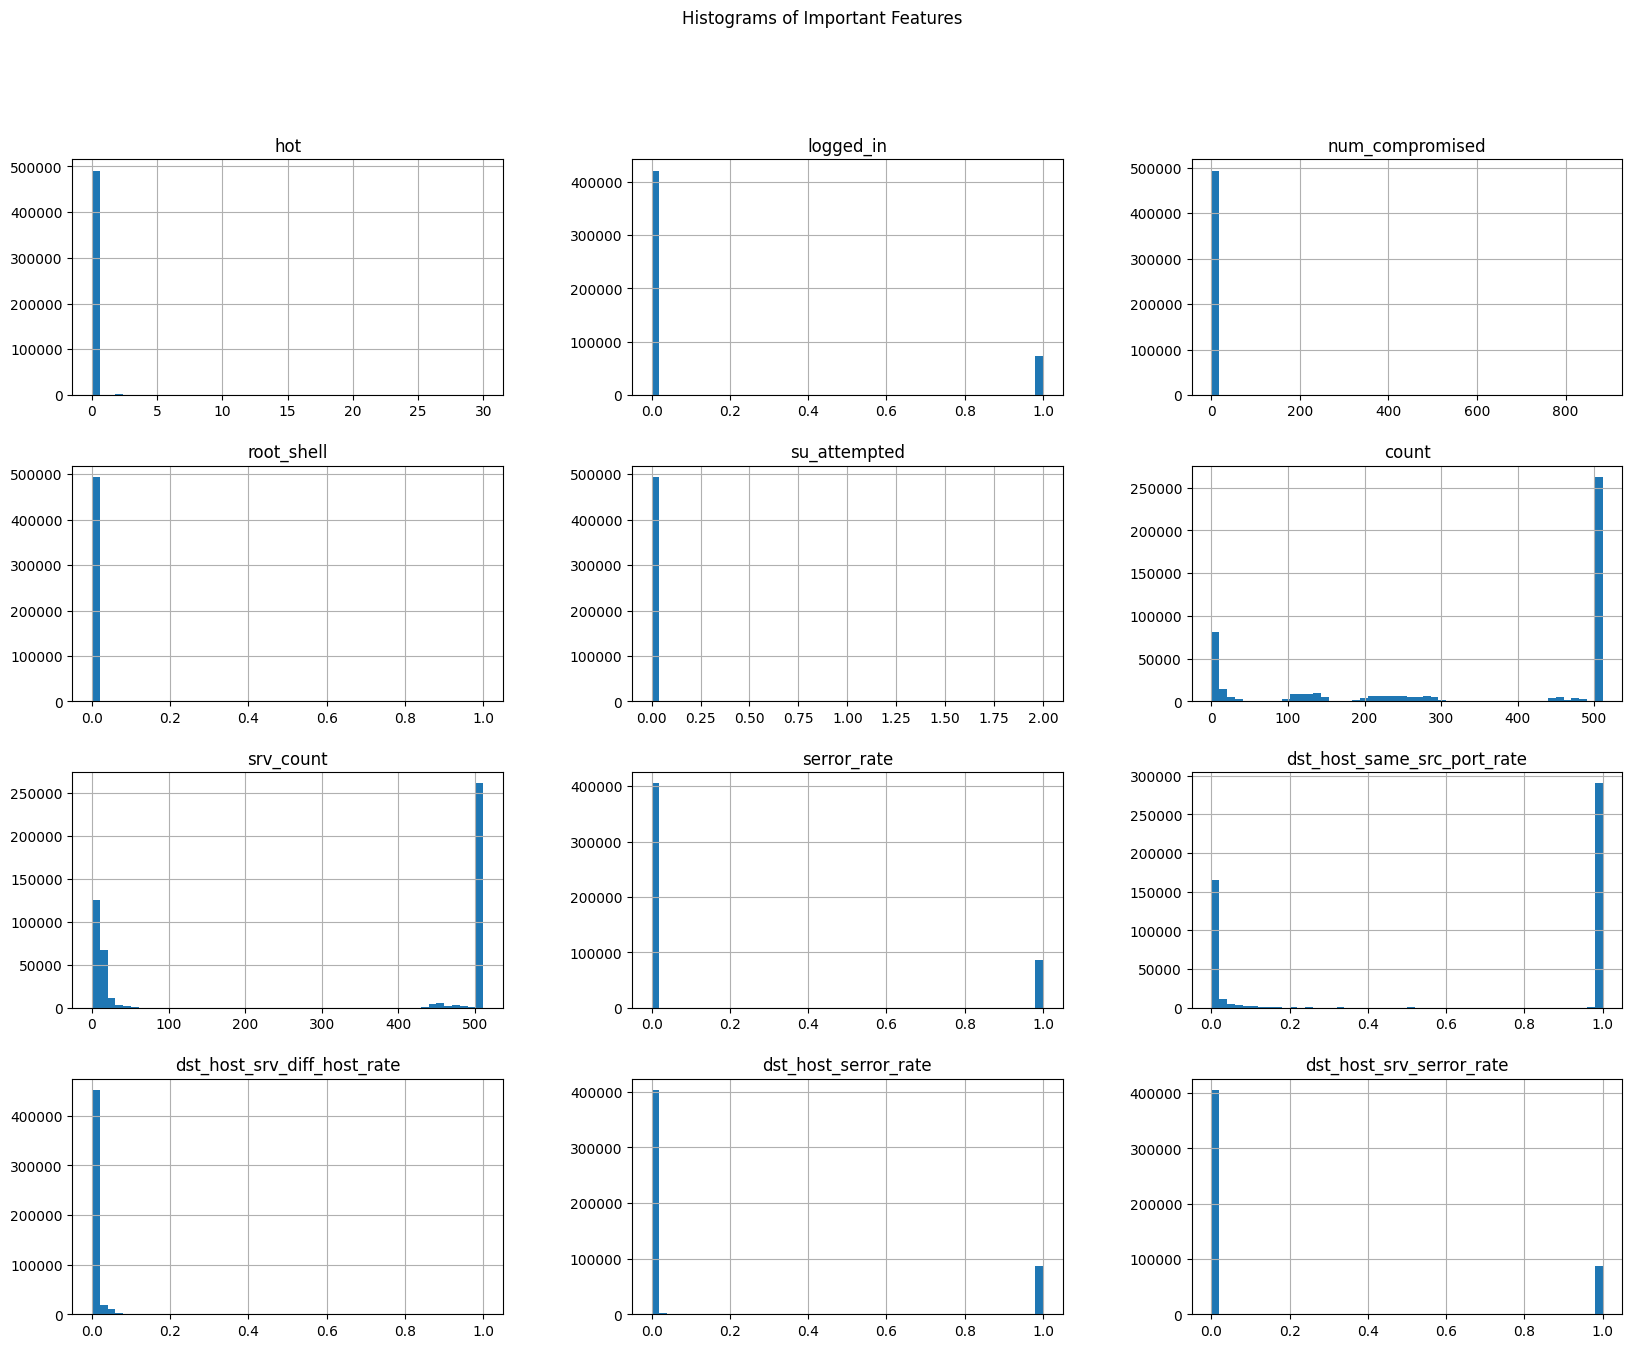

In [21]:
data_numeric = data.drop(columns=["protocol_type", "service", "flag", "label"])

# missing values (if any)
data_numeric = data_numeric.fillna(data_numeric.mean())


# important features
important_features = [
    "hot", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "count", "srv_count", "serror_rate", "dst_host_same_src_port_rate", 
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
]

# and their histograms
data[important_features].hist(bins=50, figsize=(20, 15))
plt.suptitle('Histograms of Important Features')
plt.show()

### 4. Data preprocessing

In [22]:
# standartization

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

### 5. Anomaly detection

Chosen parametres:

contamination_factor - to which proportion we expect anomalies to appear.

Due to the nature of the dataset (high rate of attacks) - 0.4 was chosen (0.1 is usually used)

random_state (in CBLOF) - fixed value to ensure consistency

5.1. Isolation Forest

How does it work: 
- using random subsamples of the data, isolation trees are created (binary search trees)
- for each data point, path lenghts are computed
- an anomaly score is computed based on the avg path length
- anomalies are then detected
- speedy for large datasets (such as ours) due to its O(n) complexity

In [ ]:

                    # believed to be anomalies
iso_forest = IForest(contamination=0.4, random_state=42)
iso_forest.fit(data_scaled)

anomalies_iforest = iso_forest.predict(data_scaled)
anomalies_iforest = np.where(anomalies_iforest == 1, "attack", "safe")
data['prediction_iforest'] = anomalies_iforest

# count safe and attack predictions
counts_iforest = data['prediction_iforest'].value_counts()

5.2. CBLOF - Cluster-Based Local Outlier Factor

How does it work:
- clustering (via KNN for example)
- the CBLOF score is calculated for each point, based on its' inclusion in a cluster
    - small clusters: CBLOF = size_of_cluster * distance_to_nearest_large_cluster_centroid
    - big   clusters: CBLOF = size_of_cluster * distance_to_cluster_centroid
- high scores are selected, being specific for anomalies

In [ ]:
cblof = CBLOF(contamination=0.4, random_state=42)
cblof.fit(data_scaled)

anomalies_cblof = cblof.predict(data_scaled)
anomalies_cblof = np.where(anomalies_cblof == 1, "attack", "safe")
data['prediction_cblof'] = anomalies_cblof

# count safe and attack predictions
counts_cblof = data['prediction_cblof'].value_counts()

5.3. COPOD - Copula-Based Outlier Detection

How does it work:
- marginal distributions for each feature are computed
- copulas are constructed - describing dependecies between the features
- points in low probabilty zones in the copula distributions are marked as anomalies

In [ ]:
copod = COPOD(contamination=0.4)
copod.fit(data_scaled)

anomalies_copod = copod.predict(data_scaled)
anomalies_copod = np.where(anomalies_copod == 1, "attack", "safe")
data['prediction_copod'] = anomalies_copod

# count safe and attack entries
counts_copod = data['prediction_copod'].value_counts()

### 6. Comparing the results

6.1. Numerical standpoint comparision

In [26]:
label_counts = data['label'].value_counts()
non_normal_entries = label_counts.drop('normal', errors='ignore').sum()

summary_df = pd.DataFrame({
    'Unsafe as per dataset': [non_normal_entries, non_normal_entries, non_normal_entries],
    'Model': ['Isolation Forest', 'CBLOF', 'COPOD'],
    'Safe': [counts_iforest.get('safe', 0), counts_cblof.get('safe', 0), counts_copod.get('safe', 0)],
    'Attack': [counts_iforest.get('attack', 0), counts_cblof.get('attack', 0), counts_copod.get('attack', 0)],
})

# Display the summary DataFrame
print(summary_df)

print("-------------------------------------------------------------------")

# Count the number of each type of attack for each model
attack_types_iforest = data[data['prediction_iforest'] == 'attack']['label'].value_counts()
attack_types_cblof = data[data['prediction_cblof'] == 'attack']['label'].value_counts()
attack_types_copod = data[data['prediction_copod'] == 'attack']['label'].value_counts()

label_counts = data['label'].value_counts()

# Create a summary DataFrame for attack types
attack_summary_df = pd.DataFrame({
    'Attack Type': attack_types_iforest.index,
    'Actual Count': label_counts.reindex(attack_types_iforest.index, fill_value=0).values,
    'Isolation Forest': attack_types_iforest.values,
    'CBLOF': attack_types_cblof.reindex(attack_types_iforest.index, fill_value=0).values,
    'COPOD': attack_types_copod.reindex(attack_types_iforest.index, fill_value=0).values
})

# Display the attack summary DataFrame
print(attack_summary_df)


   Unsafe as per dataset             Model    Safe  Attack
0                 494021  Isolation Forest  444619   49402
1                 494021             CBLOF  444639   49382
2                 494021             COPOD  444632   49389
-------------------------------------------------------------------
         Attack Type  Actual Count  Isolation Forest  CBLOF  COPOD
0           neptune.        107201             23805    515  25459
1            normal.         97278             18168  40023  18157
2              back.          2203              2197   2188   2201
3             satan.          1589              1524   1580   1457
4           ipsweep.          1247              1172   1247     96
5         portsweep.          1040              1039   1040   1032
6          teardrop.           979               533    979    125
7       warezclient.          1020               390   1008    411
8               pod.           264               208    264    194
9              nmap.      

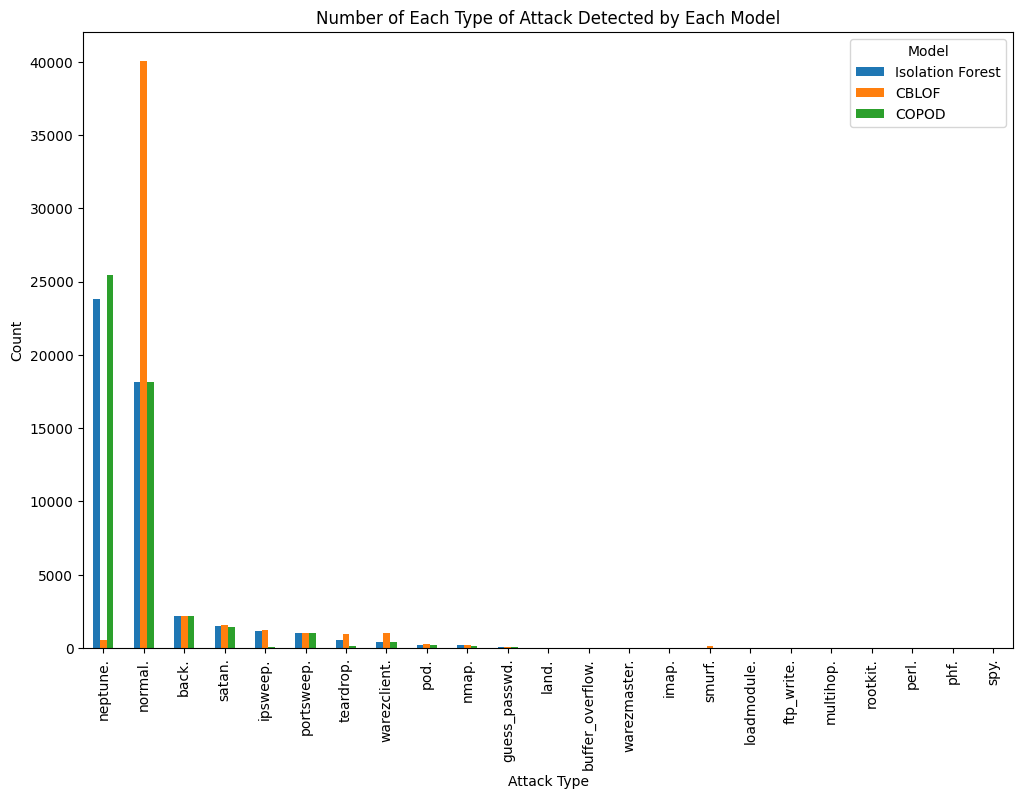

In [27]:
# Only for plotting
attack_summary_df_plot = pd.DataFrame({
    'Attack Type': attack_types_iforest.index,
    # 'Actual Count': label_counts.reindex(attack_types_iforest.index, fill_value=0).values,
    # Actual count is very high, so we will not include it in the plot
    'Isolation Forest': attack_types_iforest.values,
    'CBLOF': attack_types_cblof.reindex(attack_types_iforest.index, fill_value=0).values,
    'COPOD': attack_types_copod.reindex(attack_types_iforest.index, fill_value=0).values
})

# Plot the attack types
attack_summary_df_plot.set_index('Attack Type').plot(kind='bar', figsize=(12, 8))
plt.title('Number of Each Type of Attack Detected by Each Model')
plt.ylabel('Count')
plt.xlabel('Attack Type')
plt.legend(title='Model')
plt.show()

6.2. Procent-wise performance

In [28]:
attack_percents_df = pd.DataFrame({
    'Attack Type': attack_types_iforest.index,
    'Actual Count': label_counts.reindex(attack_types_iforest.index, fill_value=0).values,
})

attack_percents_df['Isolation Forest %'] = (attack_summary_df['Isolation Forest'] / attack_summary_df['Actual Count']) * 100
attack_percents_df['CBLOF %'] = (attack_summary_df['CBLOF'] / attack_summary_df['Actual Count']) * 100
attack_percents_df['COPOD %'] = (attack_summary_df['COPOD'] / attack_summary_df['Actual Count']) * 100

print(attack_percents_df)

         Attack Type  Actual Count  Isolation Forest %     CBLOF %     COPOD %
0           neptune.        107201           22.205950    0.480406   23.748846
1            normal.         97278           18.676371   41.142910   18.665063
2              back.          2203           99.727644   99.319110   99.909215
3             satan.          1589           95.909377   99.433606   91.692889
4           ipsweep.          1247           93.985565  100.000000    7.698476
5         portsweep.          1040           99.903846  100.000000   99.230769
6          teardrop.           979           54.443309  100.000000   12.768131
7       warezclient.          1020           38.235294   98.823529   40.294118
8               pod.           264           78.787879  100.000000   73.484848
9              nmap.           231           87.878788  100.000000   44.588745
10     guess_passwd.            53          100.000000  100.000000  100.000000
11             land.            21          100.0000

Conclusions:
- the models perform well on attacks depending on 1 or few parametres (guess_passwd, perl script, back, ftp_write).
- on neptune attacks (SYN flood over multiple services) and attacks depending of many parametres, performances are weak
- CBLOF performs very well compared to the others on warezclient, ftp_write and pod (based on a small number of parametres, between 3 and around 8-9) due to its' cluster-based logic.
- COPOD does poorly compared to the others for reconnaisance attempts (nmap - high syn/ack rates over services)
- Abisimal performance on smurf attacks, which are highly complex.


6.3. Silhouette and Dunn index for CBLOF - being the cluster-based method of the three

In [29]:
# DataFrame with the CBLOF prediction percentages
cblof_percentages_df = pd.DataFrame({
    'CBLOF %': (attack_summary_df['CBLOF'] / attack_summary_df['Actual Count']) * 100
}).fillna(0)  # Fill NaN values with 0

# round to 2 dec
cblof_percentages_df = cblof_percentages_df.round(2)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cblof_percentages_df)

silhouette_avg = silhouette_score(cblof_percentages_df, clusters)
print(f'Silhouette Score for CBLOF: {silhouette_avg}')

# cluster labels for each attack type
cblof_percentages_df['Cluster'] = clusters
print(cblof_percentages_df)

Silhouette Score for CBLOF: 0.9522736968853289
    CBLOF %  Cluster
0      0.48        1
1     41.14        2
2     99.32        0
3     99.43        0
4    100.00        0
5    100.00        0
6    100.00        0
7     98.82        0
8    100.00        0
9    100.00        0
10   100.00        0
11   100.00        0
12   100.00        0
13   100.00        0
14   100.00        0
15     0.05        1
16   100.00        0
17   100.00        0
18   100.00        0
19   100.00        0
20   100.00        0
21   100.00        0
22   100.00        0


Silhouette scores are either very close to 1 or 0, meaning the CBLOF method is a 'hit or miss'

6.4. Precision, recall, F1 Score, ROC-AUC and confusion matrix for Isolation Forest and COPOD

In [30]:
true_labels = data['label'].apply(lambda x: 1 if x != 'normal.' else 0)  # 1 for attack, 0 for normal
predictions_iforest = data['prediction_iforest'].apply(lambda x: 1 if x == 'attack' else 0)
predictions_copod = data['prediction_copod'].apply(lambda x: 1 if x == 'attack' else 0)

precision_iforest = precision_score(true_labels, predictions_iforest)
recall_iforest = recall_score(true_labels, predictions_iforest)
f1_iforest = f1_score(true_labels, predictions_iforest)
roc_auc_iforest = roc_auc_score(true_labels, predictions_iforest)
conf_matrix_iforest = confusion_matrix(true_labels, predictions_iforest)

precision_copod = precision_score(true_labels, predictions_copod)
recall_copod = recall_score(true_labels, predictions_copod)
f1_copod = f1_score(true_labels, predictions_copod)
roc_auc_copod = roc_auc_score(true_labels, predictions_copod)
conf_matrix_copod = confusion_matrix(true_labels, predictions_copod)

print("Isolation Forest Metrics:")
print(f"Precision: {precision_iforest:.2f}")
print(f"Recall: {recall_iforest:.2f}")
print(f"F1 Score: {f1_iforest:.2f}")
print(f"ROC-AUC: {roc_auc_iforest:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_iforest}")

print("\nCOPOD Metrics:")
print(f"Precision: {precision_copod:.2f}")
print(f"Recall: {recall_copod:.2f}")
print(f"F1 Score: {f1_copod:.2f}")
print(f"ROC-AUC: {roc_auc_copod:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_copod}")

Isolation Forest Metrics:
Precision: 0.63
Recall: 0.08
F1 Score: 0.14
ROC-AUC: 0.45
Confusion Matrix:
[[ 79110  18168]
 [365509  31234]]

COPOD Metrics:
Precision: 0.63
Recall: 0.08
F1 Score: 0.14
ROC-AUC: 0.45
Confusion Matrix:
[[ 79121  18157]
 [365511  31232]]


Both iforest and COPOD yield very similar results regarding classifying as safe/attack, but as was seen previously, performances regarding specific attacks vary highly.